In [23]:
from ultralytics import YOLO
import os
import pandas as pd
import cv2
import numpy as np
from scan import ImageScan
from scan import Scan
import torch
import csv
import matplotlib.pyplot as plt
from enum import Enum
from typing import Tuple
import nibabel as nib


class SliceTypes(Enum):
    SAGITTAL = "sagittal"
    CORONAL = "coronal"
    AXIAL = "axial"

In [19]:
image_directory = os.path.join(os.getcwd(), "MSLesSeg-Dataset-a", "fold5", "images")
image = "P49_T2_T1_axial_84.png"


first_image_path = os.path.join(os.getcwd(), "MSLesSeg-Dataset", "train", "P49", "T2")
first_image = "P49_T2_T1_axial_84.nii"
first_mask = "P49_T2_MASK.nii"

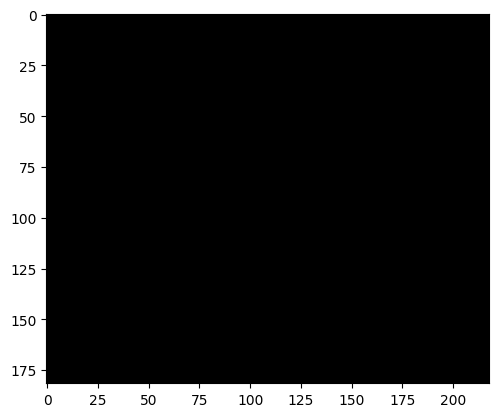

In [3]:
# Show the image
img = cv2.imread(os.path.join(image_directory, image))
plt.imshow(img)

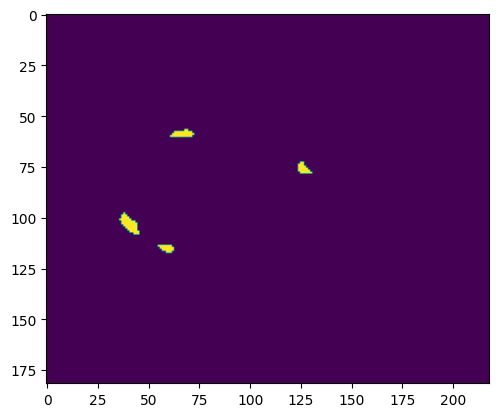

In [ ]:
scan = ImageScan(image_directory, image)
scan = scan.obtain_image_mask(os.getcwd())
scan.set_modality(f"{scan.patient}_{scan.timespan}")
# Show the mask
plt.imshow(scan)

In [17]:
def extract_contours_mask(mask: np.ndarray, scan: Scan, slice_type: SliceTypes, i: int) -> str:
    """
    Extracts the normalized coordinates of white pixels from a black and white image
    represented as a NumPy array. The output format is a string starting with '0',
    followed by normalized coordinates of white pixels (where the pixel value is 255).

    Each coordinate is normalized by the image dimensions, yielding values between 0 and 1.
    The coordinates are formatted to six decimal places.

    Parameters:
    - mask: np.ndarray
        A 2D numpy array representing the black and white image, where white pixels
        have a value of 255 and black pixels have a value of 0.

    Returns: str
        A string containing the normalized coordinates of contours found in the image in the format:
        "0 <x_center> <y_center> <width> <height> <x1> <y1> <x2> <y2> ... <xn> <yn>"
        for each contour. Each coordinate is normalized to fall between 0 and 1,
        and the values are formatted to six decimal places.
    """

    # Get the dimensions of the image
    mask = mask.astype(np.uint8)
    image_name = f"{scan.modality}_{slice_type.value}_{i}"
    plt.imsave(
            os.path.join(os.getcwd(), "MSLesSeg-Dataset-a", "masks", f"{image_name}.png"), mask, cmap="gray"
    )
    # cv2.imwrite(os.path.join(os.getcwd(), "MSLesSeg-Dataset-a", "masks", scan.), mask)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask_height, mask_width = mask.shape

    annotations = ""
    for contour in contours:
        # Get the bounding box of each object
        x, y, w, h = cv2.boundingRect(contour)

        # Calculate the center of the bounding box
        x_center = (x + w / 2) / mask_width
        y_center = (y + h / 2) / mask_height

        # Normalize the width and height
        width = w / mask_width
        height = h / mask_height

        # Write the class (assuming class 0) and the bounding box
        annotations += f"0 {x_center} {y_center} {width} {height}"

        # Add the points of the contour (normalized)
        for point in contour:
            px, py = point[0]
            annotations += f" {px/mask_width} {py/mask_height}"

        # Add a new line for each object
        annotations += "\n"

    return annotations

In [18]:
def make_slices(image: np.ndarray, scan: Scan, mask: bool = False) -> Tuple[list, list, list]:
    """
    Extracts slices from a 3D medical image along sagittal, coronal, and axial planes.

    Parameters:
    - image (np.ndarray): A 3D numpy array representing the medical image.
    - mask (bool): A flag indicating whether to extract white pixel coordinates from the slices.
                   If True, the function will process the slices to extract white pixel coordinates.

    Returns:
    - sagittal_slices (list): A list of sagittal slices extracted from the image.
    - coronal_slices (list): A list of coronal slices extracted from the image.
    - axial_slices (list): A list of axial slices extracted from the image.

    Behavior:
    - The function extracts slices along the three principal planes (sagittal, coronal, axial).
    - If the `mask` parameter is set to True, it applies the `extract_white_pixel_coordinates_mask` function
      to each slice to obtain the white pixel coordinates instead of the raw slice data.
    """

    # (IT WILL CHANGE!!!!!!)
    # Extract sagittal slices (along the first axis of the image)
    sagittal_slices = []
    for i in range(image.shape[0]):
        sagittal_slice = image[i, :, :]
        if mask:
            # Extract white pixel coordinates from the sagittal slice if mask is True
            sagittal_slice = extract_contours_mask(sagittal_slice, scan, SliceTypes.SAGITTAL, i)
        sagittal_slices.append(sagittal_slice)

    # Extract coronal slices (along the second axis of the image)
    coronal_slices = []
    for i in range(image.shape[1]):
        coronal_slice = image[:, i, :]
        if mask:
            # Extract white pixel coordinates from the coronal slice if mask is True
            coronal_slice = extract_contours_mask(coronal_slice, scan, SliceTypes.CORONAL, i)
        coronal_slices.append(coronal_slice)

    # Extract axial slices (along the third axis of the image)
    axial_slices = []
    for i in range(image.shape[2]):
        axial_slice = image[:, :, i]
        if mask:
            # Extract white pixel coordinates from the axial slice if mask is True
            axial_slice = extract_contours_mask(axial_slice, scan, SliceTypes.AXIAL, i)
        axial_slices.append(axial_slice)

    return sagittal_slices, coronal_slices, axial_slices

In [20]:
def load_nifti_image(file_path: str) -> np.ndarray:
    """
    Loads a NIfTI (.nii) file and returns its 3D image data as a NumPy array.

    Parameters:
    file_path (str): Path to the NIfTI file.

    Returns:
    numpy.ndarray: 3D array of the image data.
    """

    # Load the NIfTI file
    img = nib.load(file_path)
    # Obtain image data as a 3D numpy array
    return img.get_fdata()

/home/rorro6787/Escritorio/Universidad/4Carrera/TFG/MRI-Neurodegenerative-Disease-Detection/src/backend/MRI_system/MSLesSeg-Dataset/train/P49/T2/P49_T2_T1.nii
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '0 0.0027472527472527475 0.13073394495412843 0.005494505494505495 0.0045871559633027525 0.0 0.12844036697247707\n', '0 0.0027472527472527475 0.12614678899082568 0.005494505494505495 0.0045871559633027525 0.0 0.12385321100917432\n', '0 0.0027472527472527475 0.11697247706422019 0.005494505494505495 0.0045871559633027525 0.0 0.11467889908256881\n', '0 0.0027472527472527475 0.11697247706422019 0.005494505494505495 0.0045871559633027525 0.0 0.11467889908256881\n', '0 0.005494505494505495 0.10550458715596331 0.01098901098901099 0.01834862385321101 0.0 0.0963302752293578 0.0 0.10550458715596331 0.005494505494505495 0.11009174311926606 0.0 0.10550458715596331 0.005494505494505495 0.10091743119266056\n', '0 0.0027472527472527475 0.11467889908256881 0.00549450

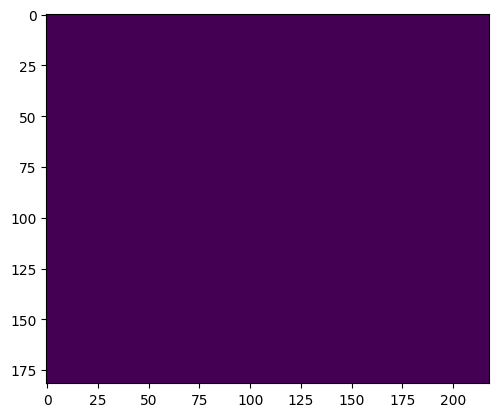

In [42]:
first_image_path = os.path.join(os.getcwd(), "MSLesSeg-Dataset", "train", "P49", "T2")
first_image = "P49_T2_T1.nii"
mask_image = os.path.join(first_image_path, first_image)
print(mask_image)

mask_image = load_nifti_image(
        os.path.join(first_image_path, first_image)
    )

scan = Scan("P49", "T2")
a = mask_image[:, :, 84]
scan.set_modality(f"{scan.patient}_{scan.timespan}")
mask_sagittal, mask_coronal, mask_axial = make_slices(mask_image, scan, mask=True)
mask_slices = [mask_sagittal, mask_coronal, mask_axial]
print(mask_slices[0])
print(mask_slices[1])
print(mask_slices[2][84])
print(a.shape)
plt.imshow(a)

In [2]:
path_mask = "/home/rorro6787/Escritorio/Universidad/4Carrera/TFG/MRI-Neurodegenerative-Disease-Detection/src/backend/MRI_system/MSLesSeg-Dataset/train/P39/T1/P39_T1_MASK.nii"
path_flair = "/home/rorro6787/Escritorio/Universidad/4Carrera/TFG/MRI-Neurodegenerative-Disease-Detection/src/backend/MRI_system/MSLesSeg-Dataset/train/P39/T1/P39_T1_FLAIR.nii"

In [16]:
def show_slices_MRI(mask_file, image_file):
    mask = nib.load(mask_file)
    img = nib.load(image_file)

    # Obtain image data as a 3D numpy array
    data_mask = mask.get_fdata()
    data_img = img.get_fdata()

    # Coronal projection (frontal view)
    coronal_slice_mask = data_mask[:, data_mask.shape[1] // 2, :]  # Take a slice in the middle
    coronal_slice_img = data_img[:, data_img.shape[1] // 2, :]  # Take a slice in the middle

    # Plot the three projections
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # guardamos la img
    plt.imsave('prueba.png', coronal_slice_img.T, cmap="gray", origin="lower")

    # Show the coronal projection
    axes[0].imshow(coronal_slice_mask.T, cmap="gray", origin="lower")
    axes[0].set_title('Coronal (Vista frontal) MASK')

    axes[1].imshow(coronal_slice_img.T, cmap="gray", origin="lower")
    axes[1].set_title('Coronal (Vista frontal) IMAGE')

    plt.show()

In [7]:
def return_slices_MRI(nii_file):
    img = nib.load(nii_file)

    # Obtain image data as a 3D numpy array
    data = img.get_fdata()

    # Coronal projection (frontal view)
    coronal_slice = data[:, data.shape[1] // 2, :]  # Take a slice in the middle

    return coronal_slice

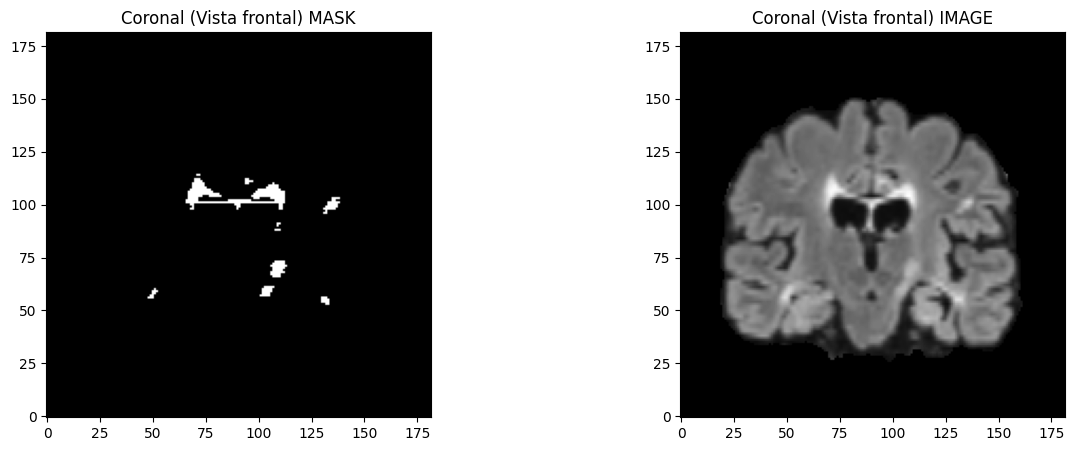

In [17]:
show_slices_MRI(path_mask, path_flair)

In [15]:
mask = return_slices_MRI(path_mask)
import cv2
import numpy as np

mask = mask.astype(np.uint8)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_height, img_width = mask.shape
print(img_height, img_width)
print("AAAAAAAAAA")
print(len(contours))


print()
print()

annotations = ""

for contour in contours:
        # Obtener el bounding box de cada objeto
        x, y, w, h = cv2.boundingRect(contour)
        
        # Calcular el centro de la caja delimitadora
        x_center = (x + w / 2) / img_width
        y_center = (y + h / 2) / img_height
        
        # Normalizar el ancho y el alto
        width = w / img_width
        height = h / img_height
        
        # Escribir la clase (suponiendo que es clase 0) y la caja delimitadora
        annotations += f'0 {x_center} {y_center} {width} {height}'

        # Añadir los puntos del polígono (normalizados)
        for point in contour:
            px, py = point[0]
            annotations += f' {px/img_width} {py/img_height}'

        # Añadir una nueva línea para cada objeto
        annotations += '\n'

print(annotations)

182 182
AAAAAAAAAA
10


0 0.5494505494505495 0.7417582417582418 0.04395604395604396 0.04395604395604396 0.5274725274725275 0.7197802197802198 0.5274725274725275 0.7252747252747253 0.532967032967033 0.7252747252747253 0.5384615384615384 0.7307692307692307 0.5384615384615384 0.7472527472527473 0.5439560439560439 0.7527472527472527 0.5494505494505495 0.7527472527472527 0.554945054945055 0.7582417582417582 0.554945054945055 0.7527472527472527 0.5604395604395604 0.7472527472527473 0.5659340659340659 0.7527472527472527 0.5659340659340659 0.7582417582417582 0.5659340659340659 0.7417582417582418 0.5604395604395604 0.7417582417582418 0.554945054945055 0.7362637362637363 0.554945054945055 0.7307692307692307 0.5494505494505495 0.7307692307692307 0.5384615384615384 0.7197802197802198 0.532967032967033 0.7252747252747253
0 0.3021978021978022 0.7252747252747253 0.02197802197802198 0.02197802197802198 0.2967032967032967 0.7142857142857143 0.2967032967032967 0.7197802197802198 0.29120879120879123 0.72

In [19]:
def show_slices_MRI(mask_file, image_file):
    mask = nib.load(mask_file)
    img = nib.load(image_file)

    # Obtain image data as a 3D numpy array
    data_mask = mask.get_fdata()
    data_img = img.get_fdata()

    # Coronal projection (frontal view)
    coronal_slice_mask = data_mask[:, data_mask.shape[1] // 2, :]  # Take a slice in the middle
    coronal_slice_img = data_img[:, data_img.shape[1] // 2, :]  # Take a slice in the middle

    # Plot the three projections
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # guardamos la img
    plt.imsave('prueba.png', coronal_slice_img.T, cmap="gray", origin="lower")

    # Show the coronal projection
    axes[0].imshow(coronal_slice_mask.T, cmap="gray", origin="lower")
    axes[0].set_title('Coronal (Vista frontal) MASK')

    axes[1].imshow(coronal_slice_img.T, cmap="gray", origin="lower")
    axes[1].set_title('Coronal (Vista frontal) IMAGE')

    plt.show()

In [20]:
path_mask = "/home/rorro6787/Escritorio/Universidad/4Carrera/TFG/MRI-Neurodegenerative-Disease-Detection/src/backend/MRI_system/MSLesSeg-Dataset/train/P39/T1/P39_T1_MASK.nii"
path_flair = "/home/rorro6787/Escritorio/Universidad/4Carrera/TFG/MRI-Neurodegenerative-Disease-Detection/src/backend/MRI_system/MSLesSeg-Dataset/train/P39/T1/P39_T1_FLAIR.nii"

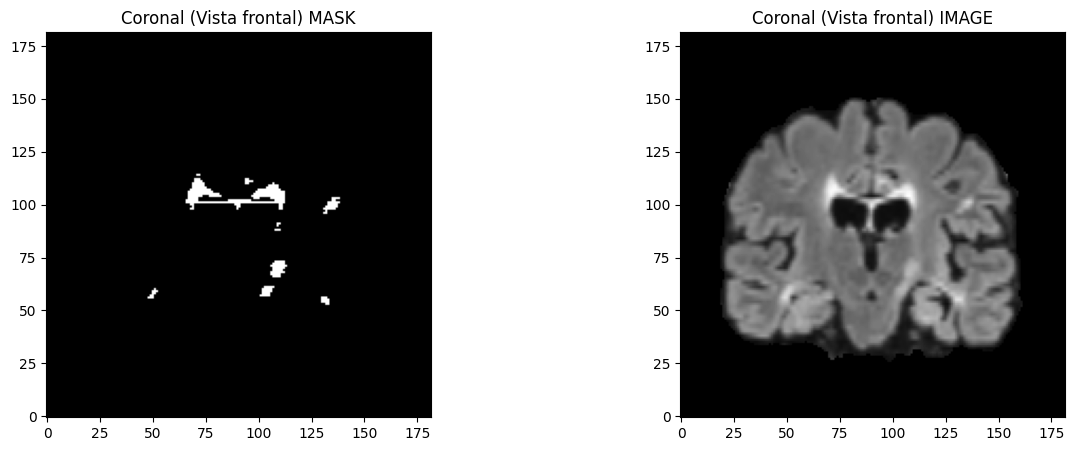

In [21]:
show_slices_MRI(path_mask, path_flair)

In [22]:
def return_slices_MRI(nii_file):
    img = nib.load(nii_file)

    # Obtain image data as a 3D numpy array
    data = img.get_fdata()

    # Coronal projection (frontal view)
    coronal_slice = data[:, data.shape[1] // 2, :]  # Take a slice in the middle
    # guardamos la imagen
    plt.imsave('prueba.png', coronal_slice.T, cmap="gray", origin="lower")

In [41]:
return_slices_MRI(path_flair)

In [32]:
def tryYOLO(image_name: str, model="yolov8n-seg-me.pt"):
    import os
    from ultralytics import YOLO
    # Load the YOLOv5 model
    model_path = os.path.join(os.getcwd(), model)

    model = YOLO(model=model_path, task="segment", verbose=False)
    print(image_name)
    # Load an image
    img = os.path.join(os.getcwd(), 'uploads', image_name)
    print(img)

    # Perform inference
    results = model(img, save = True, project=os.path.join(os.getcwd(), '..', 'images'), verbose=False)
    print(results[0].save_dir)
    # Return the path to the saved image
    return results[0]

/home/rorro6787/Escritorio/Universidad/4Carrera/TFG/MRI-Neurodegenerative-Disease-Detection/src/backend/uploads/prueba.png
/home/rorro6787/Escritorio/Universidad/4Carrera/TFG/MRI-Neurodegenerative-Disease-Detection/src/backend/uploads/prueba.png
Results saved to /home/rorro6787/Escritorio/Universidad/4Carrera/TFG/MRI-Neurodegenerative-Disease-Detection/src/backend/MRI_system/../images/predict7
/home/rorro6787/Escritorio/Universidad/4Carrera/TFG/MRI-Neurodegenerative-Disease-Detection/src/backend/MRI_system/../images/predict7


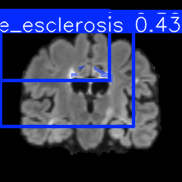

In [40]:
a = tryYOLO("/home/rorro6787/Escritorio/Universidad/4Carrera/TFG/MRI-Neurodegenerative-Disease-Detection/src/backend/uploads/prueba.png")
a.show()
# guardamos la imgagen generada por la YoLo
#plt.imsave('prueba2.png', a, cmap="gray", origin="lower")




image 1/1 /home/rorro6787/Escritorio/Universidad/4Carrera/TFG/MRI-Neurodegenerative-Disease-Detection/src/backend/MRI_system/prueba.png: 320x320 2 multiple_esclerosiss, 8.5ms
Speed: 0.8ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 320)


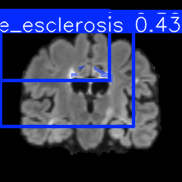

In [28]:
import os
from ultralytics import YOLO

# Define the current directory and the classes
cd = os.getcwd()
classes = ['multiple_esclerosis']

# Load the YOLOv8 model
model = YOLO(os.path.join(cd, 'yolov8n-seg-me.pt'))

# Define the path to your image
image_path = os.path.join(cd, 'prueba.png')

# Ensure the image file exists
if os.path.exists(image_path):
    # Run inference on the image
    results = model(image_path)

    # Display the results
    results[0].show()
else:
    print(f"Image not found at path: {image_path}")
